# 四国八十八ヶ所・御朱印画像分類モデルのファインチューニング

このノートブックでは、四国八十八ヶ所の御朱印画像データを用いて  
Vision-Language Model（VLM）のファインチューニングを行います。  
軽量かつ高速な学習を可能にする **Unsloth** を使用し、画像＋テキスト形式のデータを  
マルチモーダル指示データ（instruction format）に変換しながら学習を進めます。

主な内容は以下の通りです：

- 学習環境とライブラリ（Unsloth, Transformers）のセットアップ  
- 御朱印画像データセットの読み込みと整形  
- 画像と指示文（instruction）を組み合わせたマルチモーダル入力の準備  
- LoRA を用いた効率的な微調整  
- 学習済みモデルの評価と推論（画像分類の動作確認）

本ノートブックは、御朱印画像を寺院ごとに分類する  
**独自モデルの構築を再現可能な形で示すこと**を目的としています。

### ライブラリのセットアップ
Unsloth および Transformers、その他学習に必要な依存関係をインストールします。
Colab かローカル環境かによってインストール方法を切り替えています。

In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.3
!pip install evaluate
!pip install --no-deps trl

## モデルとトークナイザの読み込み
事前学習済みのQwen3-VL-8B-Instructを読み込みます。
LoRA を適用し、計算量を抑えながらファインチューニングできるよう設定します。

In [2]:
from unsloth import FastVisionModel
import torch

pretrained_model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use.
    use_gradient_checkpointing = "unsloth",
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.12.5: Fast Qwen3_Vl patching. Transformers: 4.57.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.9. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

In [3]:
model = FastVisionModel.get_peft_model(
    pretrained_model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

## データセットの読み込みと整形
御朱印画像と、それに対応する説明文・寺院名ラベルを読み込みます。
Unsloth のマルチモーダルモデルが扱えるよう、
画像（image）＋テキスト（instruction）の形式へ変換します。

In [4]:
from datasets import load_dataset
data = load_dataset("kushalc1/goshuin-shikoku88")

README.md:   0%|          | 0.00/585 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1180 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/132 [00:00<?, ? examples/s]

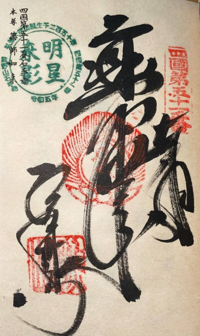

石手寺

いしてじ

寺伝によれば、神亀5年（728年）に伊予国の太守、越智玉純（おちのたまずみ）が夢によってこの地を霊地と悟り熊野十二社権現を祀った。これは聖武天皇の勅願所となり、天平元年（729年）に行基が薬師如来を刻んで本尊として安置して開基したという。創建当時の寺名は安養寺、宗派は法相宗であったが、弘仁4年（813年）に空海（弘法大師）が訪れ、真言宗に改めたとされる。寛平4年（892年）領主・河野息利に生まれた長男・息方が当寺で祈祷を受けると握っていた手から「衛門三郎再生」と書かれた石が現れたという衛門三郎再来の伝説によって石手寺と改められた。河野氏の庇護を受けて栄えた平安時代から室町時代に至る間が最盛期であり、七堂伽藍六十六坊を数える大寺院であった。永禄9年（1566年）に長宗我部元親による兵火をうけ建築物の大半を失っているが、本堂や仁王門、三重塔は焼失を免れている。

In [5]:
from IPython.display import display, Markdown

image = data["train"][8]["image"]

# Display the image
ratio = 200 / image.width
new_size = (200, int(image.height * ratio))
resized = image.resize(new_size)
display(resized)

entry = data["train"][8]

display(Markdown(entry["name"]))
display(Markdown(entry["kana"]))
display(Markdown(entry["background"]))

In [6]:
def _create_output(post):
    return f"{post['name']}（{post['kana']}）の御朱印です。{post['area']}にあります。\n{post['background']}"

instruction = "御朱印の画像から、神社名・かな・所在地・基本情報を教えてください。"

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : _create_output(sample) }]
        },
    ]
    return { "messages" : conversation }

conversation_train = [convert_to_conversation(sample) for sample in data["train"]]
conversation_test = [convert_to_conversation(sample) for sample in data["test"]]

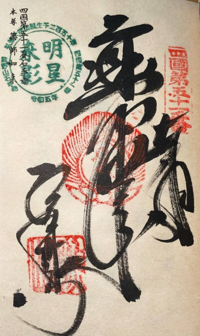

この御朱印は、「**四国霊場第51番・香石寺**」のものです。

---

### ◆ 神社名（寺院名）
**香石寺（こうせきじ）**

---

### ◆ かな（カナ表記）
**こうせきじ**

---

### ◆ 所在地
**愛知県名古屋市中村区新石田町234**

---

### ◆ 基本情報

- **正式名称**：香石寺（こうせきじ）
- **宗派**：曹洞宗
- **創立年**：1560年（永禄3年）※ 明治以降の「四国霊場」に列格されたのは1960年代以降ですが、本寺は古くから霊場としての歴史を持ちます。
- **本尊**：不動明王（不动明王）
- **開山**：日朗（にっこう）
- **旧暦開基年**：永禄3年（1560年）※ 四国霊場に列格されたのは昭


In [7]:
FastVisionModel.for_inference(model) # Enable for inference!

image = data["train"][8]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# Display the image
ratio = 200 / image.width
new_size = (200, int(image.height * ratio))
resized = image.resize(new_size)
display(resized)

# Stream the output
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

In [8]:
conversation_train[8]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': '御朱印の画像から、神社名・かな・所在地・基本情報を教えてください。'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x1344>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '石手寺（いしてじ）の御朱印です。愛媛県松山市石手2丁目9-21にあります。\n寺伝によれば、神亀5年（728年）に伊予国の太守、越智玉純（おちのたまずみ）が夢によってこの地を霊地と悟り熊野十二社権現を祀った。これは聖武天皇の勅願所となり、天平元年（729年）に行基が薬師如来を刻んで本尊として安置して開基したという。創建当時の寺名は安養寺、宗派は法相宗であったが、弘仁4年（813年）に空海（弘法大師）が訪れ、真言宗に改めたとされる。寛平4年（892年）領主・河野息利に生まれた長男・息方が当寺で祈祷を受けると握っていた手から「衛門三郎再生」と書かれた石が現れたという衛門三郎再来の伝説によって石手寺と改められた。河野氏の庇護を受けて栄えた平安時代から室町時代に至る間が最盛期であり、七堂伽藍六十六坊を数える大寺院であった。永禄9年（1566年）に長宗我部元親による兵火をうけ建築物の大半を失っているが、本堂や仁王門、三重塔は焼失を免れている。'}]}]}

In [9]:
import torch
import evaluate
from tqdm.auto import tqdm

device = "cuda"
model = FastVisionModel.for_inference(model).to(device)
model.eval()

exact_metric = evaluate.load("exact_match")

predictions = []
references = []

for entry in tqdm(data["test"]):
    image = entry["image"]
    label = entry["name"]

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": "神社名だけを教えてください（例えば：明治神宮、浅草寺、など）。"}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True
    )

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=16,
            use_cache=True,
            temperature=1.5,
            min_p=0.1,
        )

    # remove prompt tokens (batch size = 1)
    input_len = inputs["input_ids"].shape[1]
    gen_ids = output_ids[0, input_len:]

    pred = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    print(f"PREDICTION: {pred}, LABEL: {label}")

    predictions.append(pred)
    references.append(label)

# Simple exact match
exact_results = exact_metric.compute(predictions=predictions, references=references)
exact_results

  0%|          | 0/132 [00:00<?, ?it/s]

PREDICTION: 観自在寺, LABEL: 観自在寺
PREDICTION: 光耀山恩済寺, LABEL: 観音寺
PREDICTION: 天満神社, LABEL: 善通寺
PREDICTION: 井ノ頭神社, LABEL: 藤井寺
PREDICTION: 正覚山 永源寺, LABEL: 法輪寺
PREDICTION: 四国五拾六番, LABEL: 泰山寺
PREDICTION: 仙木寺, LABEL: 佛木寺   (仏木寺)
PREDICTION: 横峰寺, LABEL: 横峰寺
PREDICTION: 神社名：神峯寺, LABEL: 神峯寺
PREDICTION: 雲辺寺, LABEL: 雲辺寺
PREDICTION: 遍照金剛寺, LABEL: 浄土寺
PREDICTION: 井戸寺, LABEL: 井戸寺
PREDICTION: この画像の神社名は **新宿神社** です。, LABEL: 讃岐国分寺
PREDICTION: 金光山国分寺, LABEL: 伊予国分寺
PREDICTION: 金剛山薬師寺, LABEL: 藤井寺
PREDICTION: 大興寺, LABEL: 大興寺   (小松尾寺)
PREDICTION: 金光山國分寺, LABEL: 伊予国分寺
PREDICTION: 由霊山三角寺, LABEL: 三角寺
PREDICTION: 日野神社, LABEL: 極楽寺
PREDICTION: 医王山甲山寺, LABEL: 甲山寺
PREDICTION: 白峯寺, LABEL: 白峯寺
PREDICTION: 南光坊, LABEL: 南光坊
PREDICTION: 岩本寺, LABEL: 岩本寺
PREDICTION: 竹林山神峯寺, LABEL: 神峯寺
PREDICTION: 天満宮, LABEL: 太龍寺
PREDICTION: 金剛頂寺, LABEL: 金剛頂寺
PREDICTION: 香園寺, LABEL: 香園寺
PREDICTION: 金泉寺, LABEL: 金泉寺
PREDICTION: 佛本寺, LABEL: 佛木寺   (仏木寺)
PREDICTION: 高野山東寺, LABEL: 安楽寺
PREDICTION: 龍頭山 金剛頂寺, LABEL: 金剛頂寺
PREDICTION: 厳島神社, LABEL: 太龍寺
PRE

{'exact_match': np.float64(0.3484848484848485)}

The model only achieves 34.85% accuracy on test.

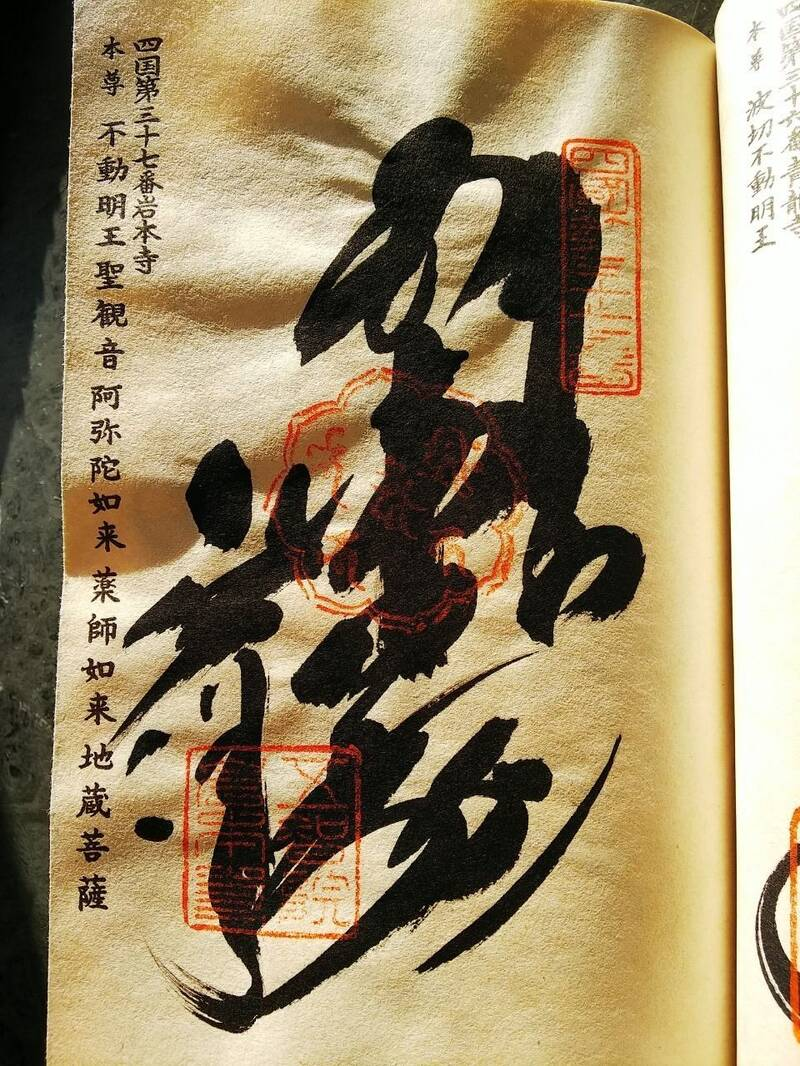

## トレーニングの設定
学習率、バッチサイズ、エポック数など、学習に必要なハイパーパラメータを設定します。
Unsloth の高速学習機能を利用し、省メモリかつ効率的に学習を行います。

## モデルの学習
指定したデータセットを使ってモデルをファインチューニングします。
画像と指示テキストを同時に入力し、寺院名の分類や説明生成が可能なモデルを訓練します。

In [13]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),  # Must use!
    train_dataset = conversation_train,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",
        # vision finetuning requirements
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [12]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
8.023 GB of memory reserved.


In [14]:
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,180 | Num Epochs = 1 | Total steps = 148
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 51,346,944 of 8,818,470,640 (0.58% trained)
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kushalfremont (kushalchat) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [huggingface_hub.inference, openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.831100
2,2.582800
3,2.385000
4,2.462800
5,2.363400
6,2.281500
7,1.903500
8,1.949300
9,1.683700
10,1.492700


KeyboardInterrupt: 

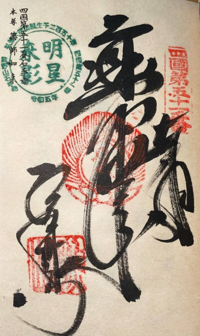

石手寺（いしじ）の御朱印です。香川県観音寺市小松町字石手寺200番地1にあります。
石手寺（いしじ）は、香川県観音寺市小松町にある寺院。宗派は真言宗大覚寺派。本尊は薬師如来で、単立の本堂を納経し、四国八十八箇所霊場に数えられている。本尊真言：おん ころころ せんだりまとうぎ そわかご詠歌：石手の かみふたて そがれぬ おがる人や こひこひ...札所等四国八十八箇所第231番札所等高松市、観音寺市ふる里いしじ（にっぽんさとうり　いしじ）文化財本堂（国の重要文化財）絹本着色薬師如来像（国の重要文化財）山門、木造梵鐘（県指定有形文化財）<|im_end|>


In [15]:
FastVisionModel.for_inference(model) # After training

image = data["train"][8]["image"]

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

# Display the image
ratio = 200 / image.width
new_size = (200, int(image.height * ratio))
resized = image.resize(new_size)
display(resized)

# Stream the output
from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

## 推論テスト（画像分類の確認）
学習済みモデルを用いて、任意の御朱印画像から分類結果や説明文を生成します。
モデルが御朱印の特徴を適切に捉えられているかを確認します。

In [18]:
import torch
import evaluate
from tqdm.auto import tqdm

device = "cuda"
model = FastVisionModel.for_inference(model).to(device)
model.eval()

exact_metric = evaluate.load("exact_match")

predictions = []
references = []

for entry in tqdm(data["test"]):
    image = entry["image"]
    label = entry["name"]

    messages = [
        {"role": "user", "content": [
            {"type": "image"},
            {"type": "text", "text": "神社名だけを漢字で教えてください（例えば：明治神宮、浅草寺、など）。かなは入りません。"}
        ]}
    ]
    input_text = tokenizer.apply_chat_template(
        messages, add_generation_prompt=True
    )

    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_new_tokens=16,
            use_cache=True,
            temperature=1.5,
            min_p=0.1,
        )

    # remove prompt tokens (batch size = 1)
    input_len = inputs["input_ids"].shape[1]
    gen_ids = output_ids[0, input_len:]

    pred = tokenizer.decode(gen_ids, skip_special_tokens=True).strip()

    print(f"PREDICTION: {pred}, LABEL: {label}")

    predictions.append(pred)
    references.append(label)

# Simple exact match
exact_results = exact_metric.compute(predictions=predictions, references=references)
exact_results

  0%|          | 0/132 [00:00<?, ?it/s]

PREDICTION: 観自在寺, LABEL: 観自在寺
PREDICTION: 思鳥寺, LABEL: 観音寺
PREDICTION: 高照寺, LABEL: 善通寺
PREDICTION: 福井寺, LABEL: 藤井寺
PREDICTION: 正覚寺, LABEL: 法輪寺
PREDICTION: 寺山寺, LABEL: 泰山寺
PREDICTION: 仙木寺, LABEL: 佛木寺   (仏木寺)
PREDICTION: 横峰寺, LABEL: 横峰寺
PREDICTION: 神峰寺, LABEL: 神峯寺
PREDICTION: 雲辺寺, LABEL: 雲辺寺
PREDICTION: 浄土寺, LABEL: 浄土寺
PREDICTION: 井戸寺, LABEL: 井戸寺
PREDICTION: 新貝寺, LABEL: 讃岐国分寺
PREDICTION: 国分寺 (こくぶじ), LABEL: 伊予国分寺
PREDICTION: 勝井寺, LABEL: 藤井寺
PREDICTION: 大興寺, LABEL: 大興寺   (小松尾寺)
PREDICTION: 国分寺（こくぶじ）, LABEL: 伊予国分寺
PREDICTION: 三角寺, LABEL: 三角寺
PREDICTION: 極楽寺, LABEL: 極楽寺
PREDICTION: 甲山寺, LABEL: 甲山寺
PREDICTION: 白峯寺, LABEL: 白峯寺
PREDICTION: 別宮山 南光坊（べっくさん なんこうぼ, LABEL: 南光坊
PREDICTION: 岩本寺, LABEL: 岩本寺
PREDICTION: 神峯寺, LABEL: 神峯寺
PREDICTION: 矢作龍光寺, LABEL: 太龍寺
PREDICTION: 金剛頂寺, LABEL: 金剛頂寺
PREDICTION: 香園寺, LABEL: 香園寺
PREDICTION: 金泉寺, LABEL: 金泉寺
PREDICTION: 栄山寺, LABEL: 佛木寺   (仏木寺)
PREDICTION: 石楽寺, LABEL: 安楽寺
PREDICTION: 金剛頂寺, LABEL: 金剛頂寺
PREDICTION: 臥衣寺, LABEL: 太龍寺
PREDICTION: 金剛福寺, LABEL: 金剛福寺
PREDIC

{'exact_match': np.float64(0.5)}

50% is still not great but much better than 33%.

## 学習済みモデルの保存
ファインチューニングしたモデルをローカルまたは Hugging Face Hub に保存します。
再利用やデプロイが可能になります。

In [19]:
model.save_pretrained("goshuin-shikoku88-finetuned")  # Local saving
tokenizer.save_pretrained("goshuin-shikoku88-finetuned")
model.push_to_hub("kushalc1/goshuin-shikoku88-finetuned", token = os.getenv("HF_TOKEN")) # Online saving
tokenizer.push_to_hub("kushalc1/goshuin-shikoku88-finetuned", token = os.getenv("HF_TOKEN")) # Online saving

README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   1%|          |  615kB /  103MB            

Saved model to https://huggingface.co/kushalc1/goshuin-shikoku88-finetuned


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-finetuned/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

In [ ]:
if True:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "goshuin-shikoku88-finetuned", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = data['test'][-1]["image"]
instruction = "御朱印の画像から、神社名・かな・所在地・基本情報を教えてください。"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)